In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [2]:
INPUT_SIZE = 784
HIDDEN_SIZE = 128
NUM_LAYERS = 3
NUM_CLASSES = 10
NUM_EPOCHS = 50
BATCH_SIZE = 50
LEARNING_RATE = 0.1

NUM_SAMPLES = 2000
NUM_TRAIN_SAMPLES = 500

In [3]:
# MNIST dataset 
dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

sample_index=list(range(NUM_SAMPLES))
train_index=list(np.random.choice(range(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False))

sample_dataset=Subset(dataset, sample_index)
train_dataset=Subset(sample_dataset, train_index)

# Data loader
TRAIN_LOADER = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

SAMPLE_LOADER = DataLoader(dataset=sample_dataset,batch_size=1,shuffle=False)

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [5]:
def get_bound(sample_loader, train_loader, num_samples, num_train, deltas):
    model = NeuralNet(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES)
    ReLU_glorot_init(model)
            
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_error=0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            train_error+=loss.item()*len(image)
    train_error=train_error/num_train

    true_error=0
    classifications=[]
    C=0
    with torch.no_grad():
        for image, label in sample_loader:
            image = image.reshape(-1, INPUT_SIZE)
            output = model(image)
            loss = criterion(output, label)
            if C<loss.item():
                C=loss.item()
            true_error+=loss.item()
            predictions=output.max(1)[1]
            classifications+=(predictions==label).tolist()
    p_Delta=len(classifications)/num_samples
    true_error=true_error/num_samples

    bounds=[]
    for delta in deltas:
        log_component = np.log((1-p_Delta+np.sqrt((1-p_Delta)**2+4*delta**(1/num_train)*p_Delta))/(2*delta**(1/num_train)))

        bounds.append(train_error+np.sqrt(C**2*log_component/2))
    
    return train_error, true_error, bounds, p_Delta

In [6]:
NUM_TESTS=50
N_DELTA=10
DELTAS=[0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.25]

train_errors=[]
test_errors=[]
p_Deltas=[]
trial_bounds=[[] for n in range(N_DELTA)]
emp_prob=np.zeros(len(DELTAS))

for k in range(NUM_TESTS):
    tr_er, ts_er, bs, p = get_bound(SAMPLE_LOADER, TRAIN_LOADER, NUM_SAMPLES, NUM_TRAIN_SAMPLES, DELTAS)
    train_errors.append(tr_er)
    test_errors.append(ts_er)
    p_Deltas.append(p)
    for n, b in enumerate(bs):
        trial_bounds[n].append(b)
        if ts_er<b:
            emp_prob[n]+=1
    print('Trial {} Training Error {:.3f} Test Error {:.3f}'.format(k+1,tr_er,ts_er))
emp_prob=emp_prob/NUM_TESTS
print(emp_prob)

Trial 1 Training Error 0.006 Test Error 0.425
Trial 2 Training Error 0.006 Test Error 0.430
Trial 3 Training Error 0.006 Test Error 0.421
Trial 4 Training Error 0.006 Test Error 0.411
Trial 5 Training Error 0.006 Test Error 0.392
Trial 6 Training Error 0.006 Test Error 0.410
Trial 7 Training Error 0.006 Test Error 0.420
Trial 8 Training Error 0.006 Test Error 0.407
Trial 9 Training Error 0.006 Test Error 0.426
Trial 10 Training Error 0.006 Test Error 0.438
Trial 11 Training Error 0.005 Test Error 0.421
Trial 12 Training Error 0.006 Test Error 0.401
Trial 13 Training Error 0.006 Test Error 0.408
Trial 14 Training Error 0.006 Test Error 0.410
Trial 15 Training Error 0.006 Test Error 0.419
Trial 16 Training Error 0.006 Test Error 0.422
Trial 17 Training Error 0.007 Test Error 0.434
Trial 18 Training Error 0.006 Test Error 0.451
Trial 19 Training Error 0.005 Test Error 0.414
Trial 20 Training Error 0.006 Test Error 0.418
Trial 21 Training Error 0.006 Test Error 0.416
Trial 22 Training Erro

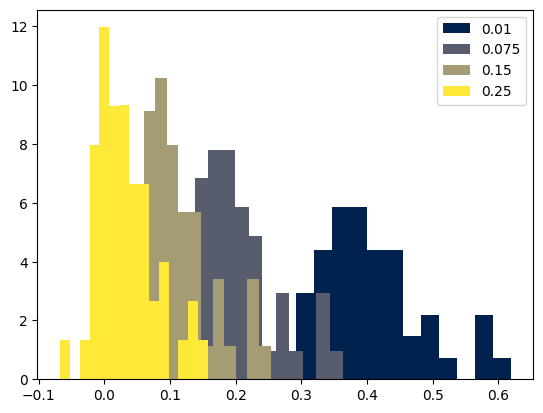

In [7]:
colors = plt.cm.cividis(np.linspace(0, 1, N_DELTA))

for m in range(2):
    for n in range(5):
        if (5*m+n)%3==0:
            ts_errs=np.array(test_errors)
            bs=np.array(trial_bounds[5*m+n])
            tightness=bs-ts_errs
            plt.hist(tightness,bins=15,density=True,label=round(DELTAS[5*m+n],3),color=colors[5*m+n])
plt.legend()

plt.savefig('plots/MNIST_Bound_Distributions.png')